<a href="https://colab.research.google.com/github/OgBasti/DataEngineering/blob/main/EoDA_2425_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engineering of Data Analysis: assignment 2

By delivering this notebook, we confirm that the code presented was developed by the following students.

**Student num:** 52255     **; Name:** Bastien Gobet

**Student num**: 56466     **; Name**:Tomas Oliveira

**DEADLINE:** 13th May, 23h59

**Only one student should deliver the notebook in a ZIP file that includes the dataset for exercise 4**
**The notebook shoud have all outputs present**


Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Anonymity_api](https://github.com/farosilva0/anonymity_api)

* [IBM differential privacy library](https://github.com/IBM/differential-privacy-library)


# Install software

In [ ]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.15+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
mkdir: cannot create directory ‘checkpoint’: File exists


In [ ]:
!pip install anonymity-api==1.0.4
!pip install diffprivlib


# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing (the same as in assignment 1). For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/assignment1


Mounted at /content/drive
adult.csv  Life_Expectancy_Data.csv  sample.csv.gz    sorted_data.csv.gz
heart.csv  sample.csv		     sorted_data.csv  tiny.csv.gz


In [ ]:
# Run this cell only if you are going to run exercise 1
!mkdir data
!cp /content/drive/MyDrive/assignment1/sample.csv data

mkdir: cannot create directory ‘data’: File exists


Next cells setup: Pandas and Spark.

In [ ]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster

from anonymity_api import anonymity
from anonymity_api import utility

In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)



/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
FILENAME_LOCAL = "data/sample.csv"
FILENAME_RMT = "/content/drive/MyDrive/assignment1/sample.csv"


## Exercise 1: local data files vs. remote data files

Compute the number of distinct licenses, accessing local file and remote file.

Compare the time it takes to execute the code for Pandas, Spark SQL and cuDF for accessing a local file and a remote file.


### Code: Pandas library

In [ ]:
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

print( "Local file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_LOCAL,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


print( "Remote file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_RMT,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))




Local file
Runtime = 15.729122161865234
Remote file
Runtime = 14.435165405273438


### Results (Pandas)

The time to process the small dataset, local file, was : (7.0721, 7.1276, 7.9830) or an average of approximately **7.39** seconds.

The time to process the small dataset, remote file, was : (9.0981, 11.4112, 12.2345) or an average of approximately **10.91** seconds.



### Spark SQL

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

print( "Local file")

start_time = time.time()
dataset = spark.read.load(FILENAME_LOCAL, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

print( "Remote file")

start_time = time.time()

dataset = spark.read.load(FILENAME_RMT, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Local file
Runtime = 4.231226921081543
Remote file
Runtime = 5.24066686630249


### Results (Spark)

The time to process the small dataset, local file, was : (5.2903, 4.7756, 4.4206) or an average of approximately **4.83** seconds.

The time to process the small dataset, remote file, was : (10.1260, 8.9522, 8.3068) or an average of approximately **9.13** seconds.



### Results discussion

For Pandas, the average time to process the local file was approximately *7.39* seconds, while the remote file took *10.91* seconds. Similarly, in Spark, the local file averaged *4.83* seconds, compared to *9.13* seconds for the remote file. These results support the typical expectation that remote file access incurs additional overhead due to network latency, transfer time and and HTTP request handling.In contrast, local file access avoids these network-related delays and benefits from faster, direct disk I/O.

Remote files, such as those retrieved from GitHub, require initiating a web request, downloading the content, and then parsing it — all of which add time, especially in environments like Colab where the physical storage and compute resources are virtualized and shared. These delays are reflected in the higher average processing times for remote datasets. These results also confirm the broader principle that data locality matters — bringing computation closer to the data, or minimizing data transfer costs, often leads to better performance.

Additionally, as seen in Assignment 1, Spark's SQL APIs yield shorter computation times compared to Pandas. This is due to Spark's ability to optimize execution plans and leverage parallelism, allowing it to process data more efficiently across available resources.

Overall, the observed behavior underscores the importance of considering both data placement and tool selection when designing data pipelines. Validating assumptions through measurement remains a critical part of effective data engineering.



## Exercise 2

The goal of this exercise is to compare results obtained with anonymized data and not anonymized. We will use a dataset with information about hear disease.

The quasi-identifiers are composed by attributes:

    * age - Age of the patient
    * sex - Gender of the patient
    * cp - Type of chest pain
    * trestbps - resting blood pressure
    * chol - cholestoral
    * fbs - fasting blood sugar > 120 mg/dl
    * restecg - resting eletrocardiographic results
    * thalach - Maximum heart rate
    * exang - Exercise induced angina
    * oldpeak - ST depression induced by exercise relative to rest
    * slope - Slope of peak exercise ST segment
    * ca - Number of major vessels colored by fluoroscopy
    * thal - Thalassemia

The sensitive-attributes are composed by only one attribute:

    * target - 1 if the patient has Hear Disease, otherwise 0

In [ ]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/assignment1/heart.csv')

# List with the quasi-identifiers
qis = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# List with the sensitive attributes
sas = ['target']


Now, let's anonymize the dataset with library anonimity_lib.

In [ ]:
# the library can automatically suggest an anonymization without the need for providing parameters
anon_df = anonymity.suggest_anonymity( df, qis, sas)

# processing information after generalization is not very simple
# the following function generate random value that keep the averahe inside each group
# used for anonymity
anon_gen_df = utility.generalize_intervals(anon_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 4.000000
Utility for k-anonymization: 0.43113462346474324

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.42370030536360015

Entropy l-diversity with l = 1.546032
Utility for entropy l-diversity: 0.41509464381280076

Recursive (c,l)-diversity with c = 2 and l = 2
Utility for recursive (c,l)-anonymization: 0.46423403265167634


Workload-aware anonymization techniques tailor the anonymization perform to the workload that will be run. For knowing more, you can check:

Kristen LeFevre, David J. DeWitt, and Raghu Ramakrishnan. 2006. Workload-aware anonymization. In Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '06). Association for Computing Machinery, New York, NY, USA, 277–286.
https://pages.cs.wisc.edu/~lefevre/WorkloadAware.pdf

Anonimity_lib supports workload-aware anonymization: https://github.com/farosilva0/anonymity_api


In [ ]:
# for queries based on intervals, you can do the following

anon_groups_df = anonymity.suggest_anonymity_groups( df, qis, sas, queries=['group(age, 20)'])
anon_groups_gen_df = utility.generalize_intervals(anon_groups_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          7
sex          2
cp           4
trestbps    10
chol        17
fbs          1
restecg      2
thalach     15
exang        2
oldpeak      8
slope        3
ca           2
thal         2
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 2.000000
Utility for k-anonymization: 0.40050894595263686

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.541577472420915

Entropy l-diversity with l = 1.482867
Utility for entropy l-diversity: 0.541577472420915

Recursive (c,l)-diversity with c = 3 and l = 2
Utility for recursive (c,l)-anonymization: 0.6478715150866264
Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per qua

Propose and compte some statistics based on groups/bins, using the original dataset, the anonymized dataset, the workload-aware anonymized dataset and a  and compare the quality of results.


In [ ]:
bins = [20, 40, 60, 80]
labels = ["20–40", "40–60", "60–80"]

datasets = {
    "Original": df.copy(),
    "Anonymized": anon_gen_df.copy(),
    "Workload-aware": anon_groups_gen_df.copy()
}

for name, data in datasets.items():
    # Age binning
    data["age_bin"] = pd.cut(data["age"], bins=bins, labels=labels, include_lowest=True)

    # Grouped stats by age bin
    grouped_stats = data.groupby("age_bin", observed=True).agg({
        "chol": "mean",
        "thalach": "max",
        "target": "size",
        "oldpeak": "var"

    }).rename(columns={"target": "count"})

    # Global stats
    global_stats = {
        "chol_mean": data["chol"].mean(),
        "chol_std": data["chol"].std(),
        "thalach_mean": data["thalach"].mean(),
        "thalach_std": data["thalach"].std(),
        "total_records": len(data),
        "age_mean": data["age"].mean(),
        "age_std": data["age"].std(),
        "age_IQR": data["age"].quantile(0.75) - data["age"].quantile(0.25)

        }
      # Convert global stats dict to a one-row DataFrame for a neater print
    global_stats_df = pd.DataFrame([global_stats])


    print(f"\n{name} Dataset Statistics (Grouped by Age Bin):\n", grouped_stats)
    print(f"\n{name} Global Statistics:\n", global_stats_df.T.rename(columns={0: "Value"}))



Original Dataset Statistics (Grouped by Age Bin):
                chol  thalach  count   oldpeak
age_bin                                      
20–40    212.894737      202     19  1.460643
40–60    244.004878      195    205  1.237010
60–80    260.151899      179     79  1.510477

Original Global Statistics:
                     Value
chol_mean      246.264026
chol_std        51.830751
thalach_mean   149.646865
thalach_std     22.905161
total_records  303.000000
age_mean        54.366337
age_std          9.082101
age_IQR         13.500000

Anonymized Dataset Statistics (Grouped by Age Bin):
                chol thalach  count   oldpeak
age_bin                                     
20–40    208.956522     198     23  0.565217
40–60    244.735135     200    185  0.909518
60–80    255.547368     184     95  1.796865

Anonymized Global Statistics:
                     Value
chol_mean      245.409241
chol_std        53.277024
thalach_mean   150.234323
thalach_std     22.669988
total_records

We computed four summary statistics per age bin ([20–40], [40–60], [60–80]) across three versions of the dataset — the original, a general anonymized version, and a workload-aware anonymized version:


*   Average cholesterol level (chol)
*   Maximum recorded heart rate (thalach)
*   Number of records per group (count)
*   Variance in ST depression (oldpeak)

**The results show that the workload-aware anonymized dataset consistently preserved key statistical properties of the original data more accurately than the general anonymized version.**

For instance, in the 60–80 age group, the average cholesterol in the original data was 260.15, and the workload-aware version closely matched this with 261.82, while the general anonymized version was slightly lower at 255.55. However, differences emerged in other metrics: the record count was 179 in the original dataset, 176 in the workload-aware version, and 184 in the general anonymized version. Likewise, the oldpeak variance was 1.51 in the original, 1.45 in the workload-aware version, and 1.80 in the general version — suggesting that general anonymization may introduce more distortion or over-smoothing in intra-group variability.

This pattern holds across other bins. In the 40–60 group, the record count was 195 in the original data, 194 in the workload-aware dataset, and 208 in the general anonymized version. Similarly, the thalach and cholesterol statistics showed closer alignment to the original in the workload-aware dataset than in the general one. For example, the average cholesterol was 244.80 (original), 241.65 (workload-aware), and 244.73 (general).

Looking at global statistics, all versions showed nearly identical mean cholesterol levels: 246.28 in the original, 245.49 in the general anonymized version, and 245.33 in the workload-aware version. However, differences appeared in measures of spread. The standard deviation of cholesterol was 51.83 in the original, 53.28 in the general anonymized version, and 54.42 in the workload-aware version. For thalach, the standard deviation was 22.91 in the original, 22.67 in the general anonymized version, and 22.77 in the workload-aware version — showing that anonymization affects data variability, with the general approach compressing it slightly and the workload-aware approach preserving it more closely.

We also examined age-related global metrics. The mean age was consistent across all datasets — 54.37 in the original, 54.38 in the general anonymized version, and 54.40 in the workload-aware version. The interquartile range (IQR) for age increased from 13.5 in the original to 15.0 in the general anonymized version, and was 13.0 in the workload-aware version — indicating some narrowing of the age distribution only under workload-aware generalization.

In summary, while both anonymization strategies preserved global averages relatively well, the workload-aware approach more effectively maintained group-level fidelity — particularly in record counts and variance — making it a more practical, reliable, and higher-utility choice for privacy-preserving data publishing when statistical accuracy is important.

## Exercise 3

The goal of this exercise is the same as before, but with a workload where the correlation between values is important.

We will be using the Life Expectancy Dataset. (https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

From this dataset we will be using the following attributes:

- Year: Year relevant to the tuple
- Status: If the country in the tuple is Developed or Developing
- Life expectancy: The life expectancy in age
- Adult Mortality: Moratlity rates (Probability of dying between the age of 15 and 60 per 1000 population)
- Infant deaths: Number of infant deaths per 1000 population
- Alcohol: Alcohol comsuption per capita (in litres)
- Hepatitis B: Hepatitis B immunization coverage aming 1-year olds (percentage)
- Measles: Number of reported meales cases per 1000 population
- BMI: Average Body Mass Index of the population
- Total Expenditure: General Government expenditure on health, as a percentage of total government expenditure

From these attributes, we will be using the Life expectancy an the sensitive attribute, with the remaining attributes as quasi-identifiers

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/assignment1/Life_Expectancy_Data.csv')
data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})
sas = ['Life expectancy ']
qis = ['Year', 'Status', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Total expenditure', 'Adult Mortality', 'infant deaths']
data = data.dropna()


<ipython-input-153-be7fa2d7f250>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})


For anonymizing, keeping correlations, you can use the following code.

In [ ]:
corr_anon = anonymity.workload_aware_k_anonymity(data, qis, 5, queries=['corr(Adult Mortality, Life expectancy )'])
gen_corr = utility.generalize_intervals(corr_anon, qis, decimals=['Alcohol', 'BMI', 'Total expenditure'])

Compare the original dataset, the workload-aware anonymized dataset and the dataset anonymized with differential privacy for computing some form of regression.

In [ ]:
# TODO complete with code for original dataset

In [ ]:
import statsmodels.api as sm

# Define the variables
X = data[qis]
y = data[sas]

# Add constant (intercept) to predictors
X_sm = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X_sm)
results = model.fit()

# Display full regression summary (coefficients, p-values, R², CI)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     338.3
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        15:35:18   Log-Likelihood:                -5059.1
No. Observations:                1649   AIC:                         1.014e+04
Df Residuals:                    1639   BIC:                         1.019e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -117.9703     64.47

The regression explains 65% of the variance in life expectancy (R-squared = 0.650). Key significant predictors (p < 0.05) include:
- Strong positive effects: Higher BMI, alcohol consumption, hepatitis B vaccination, and being a developed country (Status) significantly increase life expectancy. Year also now shows a small positive effect (p = 0.004).

- Strong negative effects: Adult mortality and infant deaths remain highly significant detractors.
- Insignificant predictors: Measles and total expenditure still lack statistical significance (p > 0.05).

### Single Predictor

In [ ]:
# Define the variables
X = data['Adult Mortality']
y = data[sas]

# Add constant (intercept) to predictors
X_sm = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X_sm)
results = model.fit()

# Display full regression summary (coefficients, p-values, R², CI)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1605.
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.38e-245
Time:                        15:35:19   Log-Likelihood:                -5364.0
No. Observations:                1649   AIC:                         1.073e+04
Df Residuals:                    1647   BIC:                         1.074e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              77.5982      0.258    3

In [ ]:
# TODO complete with code with workload-aware anonization

To run the code with the workload-aware anonymized dataset, the following transformations were applied:



```
# corr_anon = anonymity.workload_aware_k_anonymity(data, qis, 5, queries=['corr(Adult Mortality, Life expectancy )'])
```

- The k parameter ensures 5-anonymity, meaning every combination of quasi-identifiers (QIs) must appear in at least 5 records.
- The queries in argument in the anonymity function prioritizes preserving the correlation between Adult Mortality and Life expectancy, making the anonymization workload-aware (i.e., it avoids destroying useful statistical relationships).

```
# gen_corr = utility.generalize_intervals(corr_anon, qis, decimals=['Alcohol', 'BMI', 'Total expenditure'])
```

-  The generalize_intervals function takes the anonymized dataset and replaces generalized values (intervals or sets of possible values) with random values sampled from those ranges/sets. This step ensures compatibility with standard data analysis tools (e.g., correlations, means) by converting generalized data back into plausible single-point estimates.




In [ ]:
# List of columns that should be numeric but are currently of object (string) dtype beacuse of the anonymization process
cols_to_convert = [
    'Year', 'Status', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Total expenditure', 'Adult Mortality', 'infant deaths']

# Convert specified columns to numeric; set invalid parsing (errors) to NaN
gen_corr[cols_to_convert] = gen_corr[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Define predictor variables (X) and response variable (y)
X = gen_corr[qis]
y = gen_corr[sas]

# Add an intercept (constant term) to the predictor variables
X_with_const = sm.add_constant(X)

# Specify and fit the Ordinary Least Squares (OLS) regression model
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()

# Display the full regression output, including coefficients, p-values, R², and confidence intervals
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     227.4
Date:                Mon, 12 May 2025   Prob (F-statistic):          6.90e-281
Time:                        15:35:19   Log-Likelihood:                -5256.8
No. Observations:                1649   AIC:                         1.053e+04
Df Residuals:                    1639   BIC:                         1.059e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.8400     80.40

The workload-aware model explains 56.3% of variance (vs. 65.0% in the original), suggesting anonymization slightly reduced predictive power.

Preserved: Strong relationships remain significant:
- Adult Mortality (coef ≈ -0.043, p=0.000)
- Status (coef ≈ 2.91, p=0.000)
- BMI (coef ≈ 0.056, p=0.000)

Weakened: Some coefficients lost significance:
- Year became insignificant (p=0.146 vs. p=0.004 in original)
- Total expenditure remained noisy (p=0.795)


While R² dropped by ~9%, critical relationships were preserved. The target correlation (Adult Mortality ↔ Life expectancy) was preserved (highly significant, coef ≈ -0.043), confirming the workload-aware approach worked as intended.

### Single Predictor

In [ ]:
# List of columns that should be numeric but are currently of object (string) dtype beacuse of the anonymization process
cols_to_convert = ['Adult Mortality']

# Convert specified columns to numeric; set invalid parsing (errors) to NaN
gen_corr[cols_to_convert] = gen_corr[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Define predictor variables (X) and response variable (y)
X = gen_corr[qis]
y = gen_corr[sas]

# Add an intercept (constant term) to the predictor variables
X_with_const = sm.add_constant(X)

# Specify and fit the Ordinary Least Squares (OLS) regression model
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()

# Display the full regression output, including coefficients, p-values, R², and confidence intervals
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     227.4
Date:                Mon, 12 May 2025   Prob (F-statistic):          6.90e-281
Time:                        15:35:19   Log-Likelihood:                -5256.8
No. Observations:                1649   AIC:                         1.053e+04
Df Residuals:                    1639   BIC:                         1.059e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.8400     80.40

In [ ]:
# TODO complete with code with differential privacy

## Differentially Private Linear Regression with diffprivlib

In this project, we implemented a Linear Regression model using IBM's `diffprivlib` library, which enforces differential privacy (DP) during model training. The key mechanism protecting privacy in this model is the **addition of calibrated noise** to the regression coefficients, proportional to the **sensitivity** of the input data.

In `diffprivlib`, sensitivity is computed based on the **bounds of each feature**. Specifically, for each feature, sensitivity depends on the **maximum possible variation within that feature’s range**, calculated using the squared difference between the upper and lower bounds. Therefore, **accurately defining the feature bounds is crucial** — wider bounds increase sensitivity, leading to more noise and potentially reduced model utility.

The **privacy budget** (denoted by epsilon, *ε*) governs the total privacy guarantee of the model. In `diffprivlib`’s implementation, **epsilon is divided across several key steps** of the learning algorithm to ensure privacy at every stage. For instance, part of the epsilon budget is allocated to protecting the computation of intermediate values such as the covariance matrix and the regression coefficients.



### Running a Regression with Only Adult Mortality as a Predictor


In [ ]:
from diffprivlib.models import LinearRegression

# Specify the list of predictor variable(s)
qis = ['Adult Mortality']

# Extract predictor variables (X) and target variable (y)
X = data[qis]  # 'qis' is a list of column names for the predictors
y = data[sas].squeeze()  # Extract target and ensure it is a 1D array

# Compute vectors of minimum and maximum values for each predictor (for bounds specification)
mins = np.array([X[feature].min() for feature in qis])
maxs = np.array([X[feature].max() for feature in qis])

# Define bounds for X as a tuple of (min values, max values)
bounds_X = (mins, maxs)

# Define bounds for the target variable y as a tuple of (min, max)
y_lower = y.min()
y_upper = y.max()
bounds_y = (y_lower, y_upper)

# Specify and fit the differentially private linear regression model
dp_model = LinearRegression(
    epsilon=1.0,       # Differential privacy parameter (lower = stronger privacy)
    fit_intercept=True,
    bounds_X=bounds_X, # Bounds for predictor variables
    bounds_y=bounds_y, # Bounds for target variable
    random_state=42    # Ensure reproducibility
)

# Fit the model to the data
dp_model.fit(X, y)

# Display the estimated intercept term
print("Intercept:", dp_model.intercept_)

# Display the estimated coefficients for each predictor
print("\nModel Coefficients:")
for feature, coef in zip(qis, dp_model.coef_):
    print(f"{feature}: {coef:.4f}")

# Compute and display the R² score of the differentially private model
r2_dpr = dp_model.score(X, y)
print("Differentially Private Regression: R² =", r2_dpr)


Intercept: 76.02659114809157

Model Coefficients:
Adult Mortality: -0.0401
Differentially Private Regression: R² = 0.47638091312872777


The R² value is 0.476, indicating that the model explains approximately 47.6% of the variance in life expectancy. This is lower compared to the regular model's R² of 0.494 (with no differential privacy and the same predictor value), suggesting a slightly better fit for the regular model.

The decrease in R² is expected in differentially private models, as noise can reduce model accuracy and explanatory power to ensure privacy preservation.

### Running a Regression with Multiple Predictors


In [ ]:
qis = ['Year', 'Status', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Total expenditure', 'Adult Mortality', 'infant deaths']

# Extract features (X) and target (y)
X = data[qis]  # 'qis' is a list of column names used as features
y = data[sas].squeeze()  # Ensure 'y' is a 1D array

# Compute vectors of minimum and maximum values for each feature (length = number of features)
mins = np.array([X[feature].min() for feature in qis])
maxs = np.array([X[feature].max() for feature in qis])

# Define bounds_X as a tuple containing the min and max vectors
bounds_X = (mins, maxs)

# Define bounds_y (min and max of the target variable)
y_lower = y.min()
y_upper = y.max()
bounds_y = (y_lower, y_upper)

# 2. Create and fit the differentially private model
dp_model = LinearRegression(
    epsilon=1.0,       # Privacy parameter (smaller values = more privacy)
    fit_intercept=True, # Whether to calculate the intercept for this model
    bounds_X=bounds_X, # Bounds for the feature variables
    bounds_y=bounds_y, # Bounds for the target variable
    random_state=42     # Ensures reproducibility of results
)

dp_model.fit(X, y)

# 3. Access model coefficients and intercept
print("Intercept:", dp_model.intercept_)

# Print the coefficients for each feature
print("\nModel Coefficients:")
for feature, coef in zip(qis, dp_model.coef_):
    print(f"{feature}: {coef:.4f}")

# Use the differentially private model to compute the R² score
r2_dpr = dp_model.score(X, y)
print("Differentially Private Regression: R² =", r2_dpr)


Intercept: -5931.11184707405

Model Coefficients:
Year: -0.0147
Status: -0.0033
Alcohol: 0.0737
Hepatitis B: 1.3127
Measles : 1.7990
 BMI : -0.3416
Total expenditure: 0.0578
Adult Mortality: -9.1966
infant deaths: 15.4077
Differentially Private Regression: R² = -4894668.178265115


### Reasoning on the abnormal results

1. **Outliers Affect Sensitivity**:  
   The presence of **outliers** in the dataset can distort the **feature boundaries**, which in turn affects the calculated **sensitivity**. This makes the model more sensitive to noise, leading to unreliable regression results. For example, the minimum value of measles is 0 and the maximum is 131,441 (which might be incorrect, as it’s measured as cases per 1,000 people). The sensitivity is calculated as the squared difference, which adds proportionally more noise, distorting the results.

2. **Local Epsilons and Excessive Noise**:  
   The library uses **multiple local epsilons**, which add varying amounts of noise at different steps of the regression. This can result in excessive noise, overpowering the signal and causing unstable coefficients and a poor fit.




### Epsilon Effect

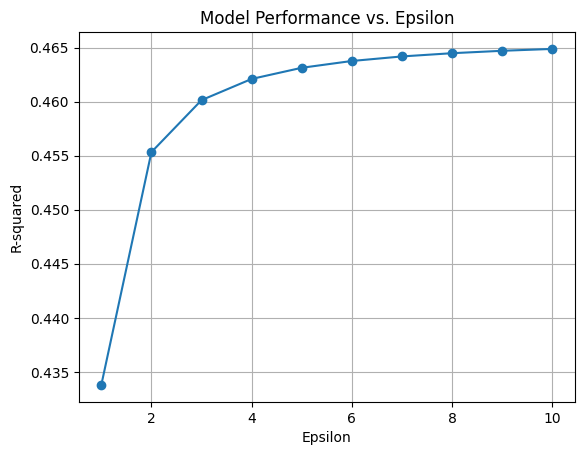

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Epsilon values to test (1 to 10)
epsilon_values = list(range(1, 11))

# List to store R-squared values for each epsilon
r2_scores = []

# Assuming 'data' is your pandas DataFrame and 'qis' and 'sas' are defined
X = data[['Adult Mortality']]  # Features
y = data[sas].squeeze()  # Target (ensure it's 1D)

# bounds_X is a list of tuples: (min, max) for each feature column
bounds_X = (X.min(), X.max())

# bounds_y is a tuple: (min, max) of the target variable
bounds_y = (y.min(), y.max())

# Iterate over different epsilon values
for epsilon in epsilon_values:
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train DP Linear Regression model with the current epsilon
    dp_model = LinearRegression(epsilon=epsilon, bounds_X=bounds_X, bounds_y=bounds_y,random_state=42)
    dp_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = dp_model.predict(X_test)

    # Calculate and store R-squared score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot the relationship between epsilon and model performance (R-squared)
plt.plot(epsilon_values, r2_scores, marker='o')
plt.xlabel("Epsilon")
plt.ylabel("R-squared")
plt.title("Model Performance vs. Epsilon")
plt.grid(True)
plt.show()

This graph shows the trade-off between privacy protection (epsilon) and model performance (R-squared) when applying differential privacy to the regression. As epsilon increases (weaker privacy), R-squared improves slightly, indicating better model accuracy at the cost of reduced privacy. The stable but low R-squared values (0.435–0.465) suggest that strong privacy guarantees (low epsilon) significantly impact predictive power, though the relationship remains measurable.

## Results Discussion

Running the regression with only one predictor (Adult Mortality) shows that there is no significant loss when comparing the normal dataset and the workload-aware anonymized dataset, since the correlation between the feature and Life Expectancy was preserved. However, the differential privacy approach reduces the R-squared of the model and leads to slightly different coefficients.

| Metric                      | Full Dataset | Workload-aware Anonymized | Differential Privacy |
|-----------------------------|--------------|---------------------------|----------------------|
| **Intercept**               | 77.6         | 77.6                      | 76.0                |
| **Adult Mortality Coefficient** | -0.05     | -0.05                     | -0.04               |
| **R-squared**               | 0.494        | 0.494                     | 0.476               |

When using all features as predictors, the workload-aware anonymization decreases the predictive power (R-squared decreased by 9%) and coefficients are slightly different. This is expected since the correlation between other features and the target variable was not fully preserved. The process of binning the values into ranges with 5-anonymity and later fulfilling those values with random numbers within the range compromised the overall model quality.  

The full model performance with IBM’s differential privacy library was not stable, and results were affected by outliers which reduced sensitivity and introduced larger noise. Nevertheless, with larger epsilon values (approximately >30), the model achieved predictive performance close to the original dataset.

### Conclusion

There are clear trade-offs between model performance and privacy. This relationship becomes more explicit as the complexity of the dataset increases (i.e., more features and non-linear relationships). Finally, the use of IBM’s differential privacy library lacks full clarity regarding the preprocessing steps required to perform linear regression, which compromised the consistency of the results once noise was introduced at multiple stages of the computations.


## Exercise 4

The goal of this exercise is to compare results obtained with anonymized and non anonymized data for more complex ML techniques.

Repeat some code you have done in ML (or some other) course using the original dataset and an anonymization using differential privacy.


#### ML task performed


In this task, we apply **KMeans clustering** to the Life Expectancy dataset in two settings:
* Using the original dataset (no anonymization)   
* Using a dataset anonymized with Differential Privacy (DP) via diffprivlib.


The goal is to evaluate how well cluster structures are preserved when privacy mechanisms are applied. This simulates a real-world scenario where sensitive data must be protected but remains useful for unsupervised learning tasks such as clustering.

Since this exercise focuses on comparing the utility of anonymized data rather than optimizing clustering performance, we do not perform extensive feature selection or hyperparameter tuning. Instead, we use a fixed set of health-related features that are relevant and interpretable:
['Alcohol', ' BMI ', 'Adult Mortality', 'Total expenditure', 'infant deaths']

We apply standard KMeans clustering with k = 3 clusters. Features are standardized prior to clustering to ensure consistent scale, and dimensionality reduction using PCA is used for visualization and to assess cluster separability.


In [ ]:
# TODO - code without differential privacy

Explained variance ratio: [0.36058791 0.19959978]
Total variance retained: 0.5601876822524348


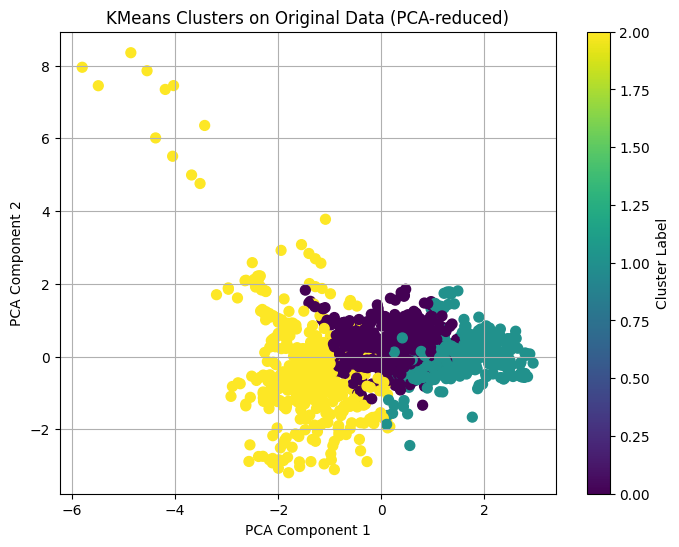

Silhouette Score (k=3): 0.2113


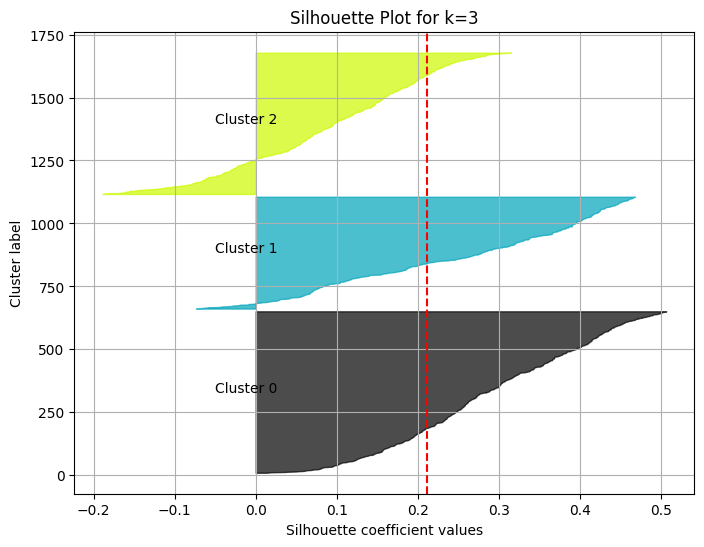

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Select and scale features
features = ['Alcohol', ' BMI ', 'Adult Mortality', 'Total expenditure', 'infant deaths']
X = data[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Fit standard KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels_original = kmeans.fit_predict(X_scaled)
data_clustered = X.copy()
data_clustered["cluster_original"] = labels_original

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance retained:", np.sum(pca.explained_variance_ratio_))

# Plot clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_original, cmap='viridis', s=50)
plt.title("KMeans Clusters on Original Data (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# --- Silhouette analysis ---

# Calculate average silhouette score
sil_score = silhouette_score(X_scaled, labels_original)
print(f"Silhouette Score (k=3): {sil_score:.4f}")

# Compute silhouette values for each point
silhouette_vals = silhouette_samples(X_scaled, labels_original)

# Create silhouette plot
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(3):
    ith_cluster_sil_vals = silhouette_vals[labels_original == i]
    ith_cluster_sil_vals.sort()
    size_cluster_i = ith_cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10  # gap between clusters

plt.axvline(x=sil_score, color="red", linestyle="--")
plt.title("Silhouette Plot for k=3")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.grid(True)
plt.show()


In [ ]:
data_clustered["cluster_original"].value_counts()

,count
cluster_original,
0,642
2,562
1,445


The PCA plot shows a visually distinguishable separation between clusters, particularly between the yellow and green clusters, while some overlap remains near the center. The silhouette score of 0.2113 indicates that the clustering structure is weak but present, with some points likely assigned to suboptimal clusters. This is consistent with the silhouette plot, where many points in each cluster have relatively low or even negative silhouette values, suggesting boundary ambiguity.

The cluster sizes are reasonably balanced (642, 562, and 445 samples), which is desirable for KMeans, though the lower cohesion in some groups implies that additional tuning or outlier removal might improve clarity. These results serve as a reasonable baseline for comparison with the differentially private version in the next step.

In [ ]:
# TODO - code with differential privacy

Explained variance ratio: [0.36058791 0.19959978]
Total variance retained: 0.5601876822524348


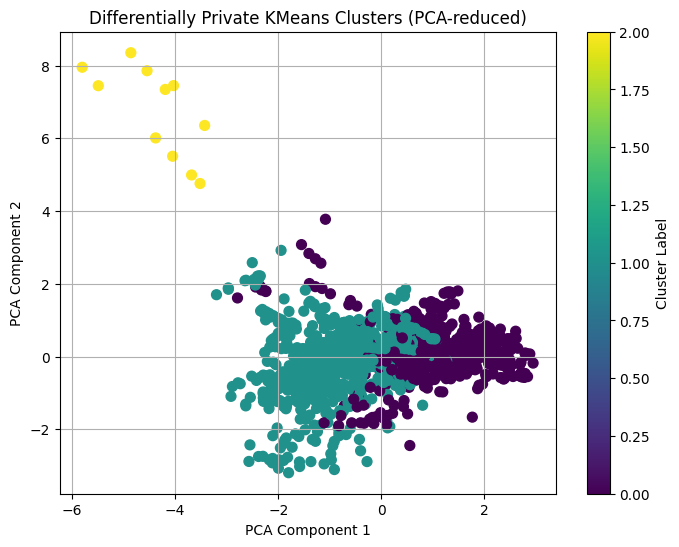

Silhouette Score (DP KMeans, k=3): 0.2470


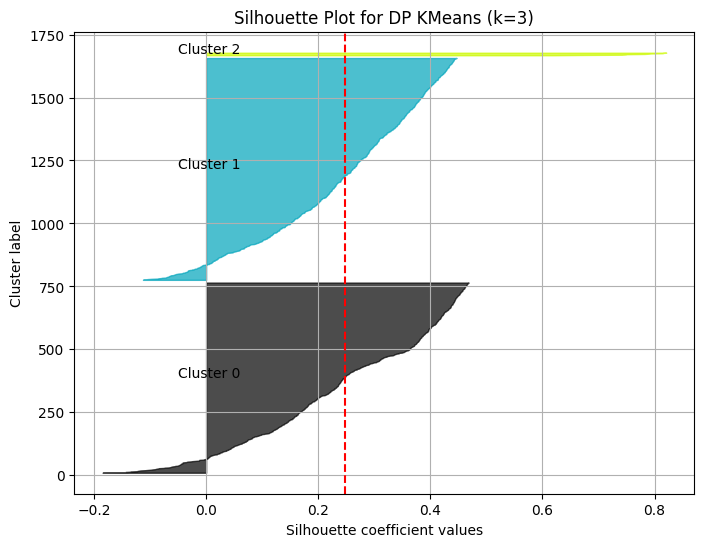

In [ ]:
from diffprivlib.models import KMeans as DPKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- Preprocessing ---
features = ['Alcohol', ' BMI ', 'Adult Mortality', 'Total expenditure', 'infant deaths']
X_dp = data[features].dropna()
X_dp_scaled = StandardScaler().fit_transform(X_dp)

# --- Fix bounds format for diffprivlib ---
mins = X_dp_scaled.min(axis=0)
maxs = X_dp_scaled.max(axis=0)
feature_bounds = (mins, maxs)  # Must be a tuple of arrays

# --- Apply DP KMeans ---
dp_kmeans = DPKMeans(n_clusters=3, epsilon=1.0, bounds=feature_bounds, random_state=42)
labels_dp = dp_kmeans.fit_predict(X_dp_scaled)
X_dp_with_clusters = X_dp.copy()
X_dp_with_clusters["cluster_dp"] = labels_dp

# --- PCA for visualization ---
pca = PCA(n_components=2)
X_pca_dp = pca.fit_transform(X_dp_scaled)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance retained:", np.sum(pca.explained_variance_ratio_))

# --- Plot DP clusters in 2D space ---
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_dp[:, 0], X_pca_dp[:, 1], c=labels_dp, cmap='viridis', s=50)
plt.title("Differentially Private KMeans Clusters (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# --- Silhouette Score ---
sil_score_dp = silhouette_score(X_dp_scaled, labels_dp)
print(f"Silhouette Score (DP KMeans, k=3): {sil_score_dp:.4f}")

# --- Silhouette Plot ---
silhouette_vals_dp = silhouette_samples(X_dp_scaled, labels_dp)

plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(3):
    ith_cluster_vals = silhouette_vals_dp[labels_dp == i]
    ith_cluster_vals.sort()
    size_cluster_i = ith_cluster_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10

plt.axvline(x=sil_score_dp, color="red", linestyle="--")
plt.title("Silhouette Plot for DP KMeans (k=3)")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.grid(True)
plt.show()



In [ ]:
X_dp_with_clusters["cluster_dp"].value_counts()

,count
cluster_dp,
1,882
0,756
2,11


### Results discussion

We compared KMeans clustering results between the original dataset and a version anonymized using Differential Privacy (DP) with `ε = 1.0`.

| Metric                     | Original KMeans | DP KMeans (ε = 1.0) |
|---------------------------|------------------|----------------------|
| Silhouette Score          | 0.2113           | 0.2470               |
| Cluster Sizes             | [642, 562, 445]  | [882, 758, 11]       |
| PCA Cluster Separation    | Moderate         | Poor (one sparse group) |
| Cohesion and Compactness  | Weak to moderate | Weak and unbalanced  |

#### Key Observations

- **Silhouette Score**: The differentially private clustering yielded a slightly higher silhouette score (0.2470) compared to the original (0.2113). However, this should be interpreted with caution, as the cluster distribution was significantly imbalanced, with only 11 samples assigned to one cluster.

- **Cluster Balance**: The original clustering produced reasonably balanced groups, which is suitable for KMeans. In contrast, the DP-KMeans model led to an uneven distribution, with one cluster dominating the others. This suggests that the added noise affected the convergence and stability of the algorithm.

- **Visual Analysis**: The PCA plots indicated that the original data exhibited moderately distinct cluster boundaries, whereas the DP-clustered data showed considerable overlap and reduced cluster separability. The sparsity of one cluster in the DP version was also visually evident.

- **Interpretability and Practical Utility**: While the original clustering offered modest utility for downstream tasks, the differentially private clustering reduced interpretability due to high distortion. This limits its usefulness in scenarios where cluster structure is important.

#### Conclusion

Applying Differential Privacy with `ε = 1.0` introduced a notable degradation in clustering quality, particularly in terms of balance and cohesion. Although privacy guarantees were maintained, the utility of the resulting clusters was compromised. For unsupervised learning tasks that require meaningful groupings, alternative approaches—such as higher values of epsilon or workload-aware anonymization—may provide a more effective trade-off between privacy and utility.
